Dans cette partie, on s'intéresse maintenant à l'étude d'un call asiatique. Le payoff ne dépend plus uniquement du prix de l'actif à l'échéance de l'option, mais dépend également du chemin suivi, il vaut : 
$$
\left(\frac{1}{N} \sum_{i=1}^N S_{t_i} - K \right)_+
$$
A la date $t$, l'option vaut donc :
$$
C_t = \mathbb{E}^Q \left(e^{-r(t-T)}\left(\sum_{i=1}^N S_{t_i}-K\right)_+|\mathcal{F}_t\right)
$$

On va étudier le prix d'un call asiatique dont le sous-jacent est l'actif risqué $S_t$, en fonction des constantes suivantes : 
 - Le taux d'intérêt                 : $r$
 - Les dates d'observation           : $t_1,...,t_N$
 - La volatilité                     : $\sigma$
 - L'échéance du call                : $T$
 - Le strike                         : $K$
 - Le prix de l'actif risqué à $t=0$ : $S_0$

In [1]:
import numpy as np 
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
dates_obs = [0.2,0.4,0.6,1]
T=1
t = 0
K = 100
sigma = 0.20
r = 0.05
S0=90
n_sim = 1000

## 2.1 Le prix de l’option asiatique en fonction de S0.

In [3]:
def Price_MC(S0,K,t,T,r,sigma,date_obs,n_sim):
    
    X = np.random.normal(0, 1, n_sim) ## nsim = 10000 à changer
    ti = date_obs[0]
    S = S0 * np.exp((r - 0.5*sigma**2)*(ti) + sigma*np.sqrt(ti)*X)
    prix = S
    for tj in date_obs[1:]:
        S =S * np.exp((r - 0.5*sigma**2)*(tj -ti) + sigma*np.sqrt(tj-ti)*np.random.normal(0, 1, n_sim))
        prix = prix +S
        ti = tj
    S = prix/len(date_obs)
    payoff = np.exp(-r*T)*np.maximum(S-K,0)
    
    
    price = np.mean(payoff)
    return price

In [4]:
def Price_BS(S,K,t,T,r,sigma):
    d1 = (np.log(S/K)+(r+sigma**2/2.)*(T-t))/(sigma*np.sqrt(T-t)) 
    
    d2 = d1-sigma*np.sqrt(T-t)
    return S*norm.cdf(d1)-K*np.exp(-r*(T-t))*norm.cdf(d2)

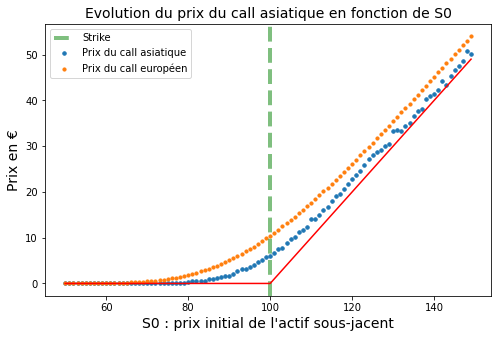

In [10]:

list_S0 = [K+i for i in range(-50,50)]
C = [Price_MC(S0,K,t,T,r,sigma,dates_obs,n_sim) for S0 in list_S0]
C_BS = [Price_BS(S0,K,t,T,r,sigma) for S0 in list_S0]



plt.figure(figsize=(8,5))
plt.axvline(x=K, ymin=0, ymax=1, color='green', alpha=0.5, linestyle='--', linewidth=4, label='Strike')
dr = [0 if i<K else i-K for i in list_S0]
plt.plot(list_S0,dr,color="red")
plt.scatter(list_S0, C,label='Prix du call asiatique',s=12)
plt.scatter(list_S0,C_BS,label="Prix du call européen",s=10)
plt.ylabel('Prix en €',fontsize=14)
plt.xlabel("S0 : prix initial de l'actif sous-jacent",fontsize=14)
plt.title("Evolution du prix du call asiatique en fonction de S0",fontsize=14)
plt.legend()

#### Commentaire
L'évolution du prix du call asiatique en fonction de $S_0$ est proche de celui du call européen, on retrouve un prix presque nul avec $S_0$ si $S_0$ est trop petit par rapport au strike, et une variation linéaire de pente 1 lorsque $S_0$ est beaucoup plus grand que le strike.

De même que précédement, l'option asiatique est moins chère que le call européen. Intuitivement, cela s'explique par le fait que lorsqu'on achète une option, on bénéficie fortement de la hausse du sous-jaçent, mais on est peu pénalisé par la baisse du sous-jaçent, car on ne peut pas perdre plus que le prix de l'option. La valeur d'une option est donc liée au potentiel du sous-jaçent à atteindre des valeurs extrêmes. Or, il est plus facile pour un actif d'atteindre une valeur extrême une fois en un instant t = T, qu'atteindre une valeur extrême sur la moyenne, car cela requiert une valeur extrême sur plusieurs instants d'observation, ce qui explique que le call européen soit plus cher que le call asiatique.

## 2.2 le prix de l’option asiatique en fonction du nombre de dates d’observations.

On s'intéresse maintenant à l'influence du nombre de dates d'observation sur le prix de l'option. On se place dans le cas où les dates sont réparties de manière régulière sur la durée de l'option, $d_1,...,d_n = \frac{1}{n},...,1$.

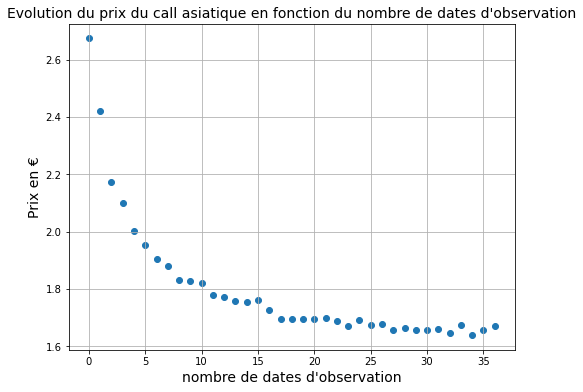

In [11]:
dates_o = lambda n : [i/n for i in range(1,n+1)]

C = [np.mean(np.array([Price_MC(S0,K,t,T,r,sigma,dates_o(i),n_sim) for j in range(100)])) for i in range(3,40)]

plt.figure(figsize=(8,6))
plt.scatter(list(range(len(C))),C)
plt.xlabel("nombre de dates d'observation",fontsize=14)
plt.ylabel("Prix en €",fontsize=14)
plt.title("Evolution du prix du call asiatique en fonction du nombre de dates d'observation",fontsize=14)
plt.grid()

#### Commentaire
L'augmentation du nombre de dates provoque une diminution rapide du prix de le l'option au début, puis le prix semble se stabiliser autour de 0.20€. La diminution peut etre expliqué par le fait que moins il y a de dates plus on se rapproche d'un call européen, donc plus le prix augmente. 

Lorsqu'on augmente le nombre de dates, on tend vers une option asiatique à moyenne arithmétique continue, qui semble être une limite minorant le prix en fonction du nombre de dates d'observation. En effet :
$$
\lim\limits_{n \to \infty} \frac{1}{N}  \sum_{i=1}^N S_{d_i} = \lim\limits_{n \to \infty} \sum_{i=1}^N S_{d_i}(d_i-d_{i-1}) = \int_0^1 S_t dt
$$


## 2.3 Analyse des performances des méthodes de réduction de variance pour le pricing d’une option asiatique

Les simulations de Monte-Carlo sont coûteuses en temps, mais nécessaire pour évaluer le prix des produits dérivés quand on ne dispose pas de formules explicites. Pour améliorer leur efficacité, on peut utiliser des techniques de réduction de variance afin de faire converger l'estimateur plus vite, et donc réduire le nombre de simulations nécéssaires. On va étudier deux méthodes différentes : 
 - Les variables antithétiques
 - Les variables de contrôle

In [12]:
def Price_MC_classique(S0,K,t,T,r,sigma,date_obs,n_sim):
    alpha = 0.95
    
    X = np.random.normal(0, 1, n_sim) ## nsim = 10000 à changer

    
    ti = date_obs[0]
    S = S0 * np.exp((r - 0.5*sigma**2)*(ti) + sigma*np.sqrt(ti)*X)
    
    prix = S
    for tj in date_obs[1:]:
        X = np.random.normal(0, 1, n_sim)
        S =S * np.exp((r - 0.5*sigma**2)*(tj -ti) + sigma*np.sqrt(tj-ti)*X)
        
        prix = prix +S
        ti = tj
        
    S = prix/len(date_obs)
    
    payoff = np.exp(-r*T)*np.maximum(S-K,0)

    
    
    variance=[0]
    d = 0
    m = payoff[0]
    for i in range(1,n_sim):
        delta = payoff[i]-m
        m=m+delta/(i+1)
        d=d+(i/(i+1))*delta**2
        variance.append(d/i)
        
    price = np.cumsum(payoff) / np.array([(i+1) for i in range(len(payoff))])
    
    return price[1:],variance[1:]

### 2.3.1 Variables antithétiques

Si $U \sim U(0,1)$ alors la variable $1-U$ suit également une loi uniforme sur $[0,1]$. Le principe de la méthode des variables antithétiques est de tirer parti de cette symétrie. Cette technique permet de générer deux variables à partir d'un tirage, et est particulièrement avantageuse si le tirage est coûteux. Néanmoins pour évaluer son efficacité, il faut comparer avec une méthode de Monte-Carlo avec $2n$ tirages.

On peut montrer que cela permet de supprimer la variance liée à la partie impaire du payoff, on s'attend donc à ce qu'un Monte-Carlo avec variable antithétique à $n$ tirage ait toujours une variance plus faible qu'un Monte-Carlo classique à $2n$ tirages.

On commence par afficher l'évolution de l'estimation du prix du call asiatique en fonction du nombre d'itération pour constater celui qui converge le plus rapidement. L'estimation avec variable antithétique n'est mise à jour qu'une itération sur deux pour être équitable avec l'estimation classique.

In [13]:
def Price_MC_A(S0,K,t,T,r,sigma,date_obs,n_sim):
    alpha = 0.95
    
    X = np.random.normal(0, 1, n_sim) ## nsim = 10000 à changer
    X_antithetic = -X
    
    ti = date_obs[0]
    S = S0 * np.exp((r - 0.5*sigma**2)*(ti) + sigma*np.sqrt(ti)*X)
    S_antithetic = S0 * np.exp((r - 0.5*sigma**2)*(ti) + sigma*np.sqrt(ti)*X_antithetic)
    
    prix = S
    prix_antithetic = S_antithetic
    for tj in date_obs[1:]:
        X = np.random.normal(0, 1, n_sim)
        X_antithetix = -X
        S =S * np.exp((r - 0.5*sigma**2)*(tj -ti) + sigma*np.sqrt(tj-ti)*X)
        S_antithetic = S * np.exp((r - 0.5*sigma**2)*(tj -ti) + sigma*np.sqrt(tj-ti)*X_antithetic)
        
        prix = prix +S
        prix_antithetic = prix_antithetic + S_antithetic
        ti = tj
        
    S = prix/len(date_obs)
    S_antithetic = prix_antithetic/len(date_obs)
    
    payoff = np.exp(-r*T)*np.maximum(S-K,0)
    payoff_antithetic = np.exp(-r*T)*np.maximum(S_antithetic-K,0)

    
    payoff_concat = (payoff +payoff_antithetic)/2
    
    variance=[0]
    d = 0
    m = payoff_concat[0]
    for i in range(1,n_sim):
        delta = payoff_concat[i]-m
        m=m+delta/(i+1)
        d=d+(i/(i+1))*delta**2
        variance.append(d/i)
        
    price = np.cumsum(payoff_concat) / np.array([(i+1) for i in range(n_sim)])
    
    return price[1:],variance[1:]

Text(0.5, 1.0, "Evolution de l'écart-type de l'estimateur en fonction du nombre d'itérations dans une échelle logarithmique")

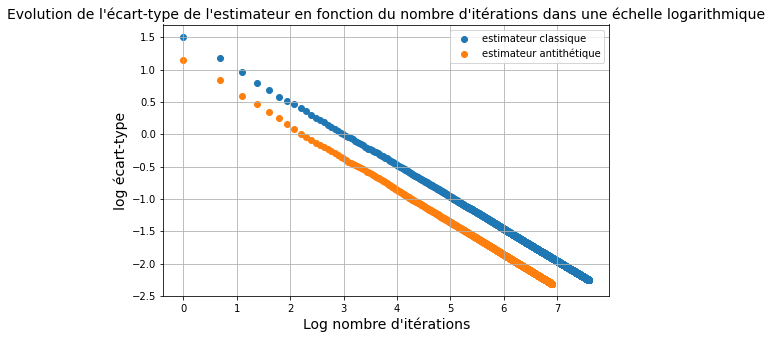

In [14]:
S = 80
n_sim = 1000

real_price = Price_BS(S,K,t,T,r,sigma)

var = []
pr=[]

var_A = []
pr_A = []

## on moyenne les résultats sur plusieurs estimations afin de lisser les courbes 
for i in range(500):
    
    price,variance = Price_MC_classique(S0,K,t,T,r,sigma,dates_obs,2*n_sim)
    price_A,variance_A = Price_MC_A(S0,K,t,T,r,sigma,dates_obs,n_sim)
    
    var.append(variance)
    pr.append(price)
    var_A.append(variance_A)
    pr_A.append(price_A)

v = np.mean(np.array(var),axis=0)
v_A = np.mean(np.array(var_A),axis=0)
    
    
    
iterations = [i for i in range(1,2*n_sim)]
iterations_A = [i for i in range(1,n_sim)]

plt.figure(figsize=(8,5))
plt.scatter(np.log(iterations),np.log(np.sqrt(v / np.array(list(range(1,2*n_sim))))),label = "estimateur classique")
plt.scatter(np.log(iterations_A),np.log(np.sqrt(v_A / np.array(list(range(1,n_sim))))),label="estimateur antithétique")
plt.ylabel('log écart-type',fontsize=14)
plt.xlabel("Log nombre d'itérations", fontsize=14)
plt.grid()
plt.legend()
plt.title("Evolution de l'écart-type de l'estimateur en fonction du nombre d'itérations dans une échelle logarithmique", fontsize=14)

##### Facteur de réduction de la variance

In [21]:
print("facteur de réduction de la variance : ",v[-1]/v_A[-1])

facteur de réduction de la variance :  2.24241016293512


### 2.3.2 Variables de contrôle

Lorsqu'on cherche à estimer l'espérance d'une variable aléatoire $X$, on a parfois facilement accès à l'espérance d'une autre variable aléatoire $Y$ qui est corrélée à $X$. L'idée est alors de simuler une autre variable suivant la loi de $Y$ en plus de $X$ et de considérer le nouvel estimateur : $C_c = \frac{1}{n} \sum_{i=1}^n x_i + c(z_i - E(Z))$.

Cet estimateur reste non biaisé, mais pour un $c$ bien choisi offre une grande réduction de variance d'autant plus grande que les variables $X$ et $Y$ sont corrélées.

Nous allons comparer la performance de l'estimateur de Monte-Carlo classique avec celle de 3 autres estimateurs issus de 3 variables de contrôle différentes : 
 - $Z_1 = S_T$
 - $Z_2 = \frac{1}{N} \sum_{i=1}^N S_{t_i}$
 - $Z_3 = e^{-rT}(S_T-K)_+$
 
De même que précédemment, on fixe $S_0$ et $t$, et pour un grand nombre de $n$ différents, on calcule 10 000 fois le prix estimé avec chaque méthode, et on estime la variance de chaque méthode en fonction de $n$. 

In [15]:
def variance_list(liste):
    variance_liste=[]
    d = 0
    m = liste[0]
    for i in range(1,len(liste)):
        delta = liste[i]-m
        m=m+delta/(i+1)
        d=d+(i/(i+1))*delta**2
        variance_liste.append(d/i)
    return variance_liste

In [16]:
def Price_MCC(S0,K,t,T,r,sigma,date_obs,n_sim):
    
    X = np.random.normal(0, 1, n_sim) ## nsim = 10000 à changer
    ti = date_obs[0]
    S = S0 * np.exp((r - 0.5*sigma**2)*(ti) + sigma*np.sqrt(ti)*X)
    prix = S
    for tj in date_obs[1:]:
        S =S * np.exp((r - 0.5*sigma**2)*(tj -ti) + sigma*np.sqrt(tj-ti)*np.random.normal(0, 1, n_sim))
        prix = prix +S
        
        ti = tj
    
    prix = prix/len(date_obs)
    
    payoff = np.exp(-r*T)*np.maximum(prix-K,0)
    
    Z1 = S
    Z2  = prix
    Z3 = np.exp(-r*T)*np.maximum(S-K,0)
    
#     Z3 = np.mean([S0 * np.exp((r - 0.5*sigma**2)*(ti) + sigma*np.sqrt(ti)*np.random.normal(0, 1, n_sim)) for ti in date_obs],axis=0)
    
        
    ##
    e1 = S0*np.exp(r*T)
    e2 = np.mean([S0*np.exp(r*ti) for ti in date_obs])
    e3 = Price_BS(S0,K,t,T,r,sigma)
    
    
    
    c1 = -np.sum((payoff - np.mean(payoff)) * (Z1 - np.mean(Z1)))/ np.sum((Z1 - np.mean(Z1))**2)
    c2 = -np.sum((payoff - np.mean(payoff)) * (Z2 - np.mean(Z2)))/ np.sum((Z2 - np.mean(Z2))**2)
    c3 = -np.sum((payoff - np.mean(payoff)) * (Z3 - np.mean(Z3)))/ np.sum((Z3 - np.mean(Z3))**2)
    
    
    variance=variance_list(payoff)
    variance1 = variance_list(payoff + c1*(Z1-e1))
    variance2 =  variance_list(payoff + c2*(Z2-e2))
    variance3 = variance_list(payoff + c3*(Z3-e3))
    
    
    price3 = np.cumsum(payoff + c3*(Z3-e3)) / np.array([(i+1) for i in range(n_sim)])
    price2 = np.cumsum(payoff + c2*(Z2-e2)) / np.array([(i+1) for i in range(n_sim)])
    price1 = np.cumsum(payoff + c1*(Z1-e1)) / np.array([(i+1) for i in range(n_sim)])
    price =np.cumsum(payoff) / np.array([(i+1) for i in range(n_sim)])
                
    return price,price1,price2,price3,variance,variance1,variance2,variance3

Facteur de réduction de la variance pour l'estimateur 1 :  1.8696036163533851
Facteur de réduction de la variance pour l'estimateur 2 :  2.2804173707032294
Facteur de réduction de la variance pour l'estimateur 3 :  3.1179978317106416


Text(0.5, 1.0, "Evolution de l'écart-type de l'estimateur en fonction du nombre d'itérations dans une échelle logarithmique")

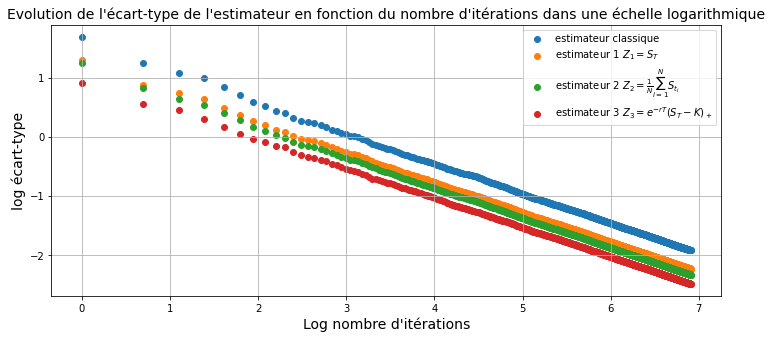

In [23]:

var,var1,var2,var3 = [],[],[],[]

n_sim=1000

## on moyenne les résultats sur plusieurs estimations afin de lisser les courbes


for i in range(100):
    
    price,price1,price2,price3,variance,variance1,variance2,variance3 = Price_MCC(S0,K,t,T,r,sigma,dates_obs,n_sim)
    
    var.append(variance)
    var1.append(variance1)
    var2.append(variance2)
    var3.append(variance3)
    
v = np.mean(np.array(var),axis=0)
v1= np.mean(np.array(var1),axis=0)
v2 = np.mean(np.array(var2),axis=0)
v3 = np.mean(np.array(var3),axis=0)

print("Facteur de réduction de la variance pour l'estimateur 1 : ",np.mean(v/v1))

print("Facteur de réduction de la variance pour l'estimateur 2 : ",np.mean(v/v2))

print("Facteur de réduction de la variance pour l'estimateur 3 : ",np.mean(v/v3))



iterations = [i for i in range(1,n_sim)]

plt.figure(figsize=(12,5))

plt.scatter(np.log(iterations),np.log(np.sqrt(v / np.array(list(range(1,n_sim))))),label = "estimateur classique")
plt.scatter(np.log(iterations),np.log(np.sqrt(v1 / np.array(list(range(1,n_sim))))),label=r"estimateur 1 $Z_1 = S_T$ ")
plt.scatter(np.log(iterations),np.log(np.sqrt(v2 / np.array(list(range(1,n_sim))))),label=r"estimateur 2 $Z_2 = \frac{1}{N} \sum_{i=1}^N S_{t_i}$")
plt.scatter(np.log(iterations),np.log(np.sqrt(v3 / np.array(list(range(1,n_sim))))),label=r"estimateur 3 $Z_3 = e^{-rT}(S_T-K)_+$")

plt.ylabel('log écart-type',fontsize=14)
plt.xlabel("Log nombre d'itérations", fontsize=14)
plt.grid()
plt.legend()
plt.title("Evolution de l'écart-type de l'estimateur en fonction du nombre d'itérations dans une échelle logarithmique", fontsize=14)

#### Commentaire
Toutes les variables de contrôle performent mieux que l'estimateur classique. On remarque qu'ensuite, $Z_2$ est plus efficace que $Z_1$ pour réduire la variance, ce qui n'est pas surprenant car dans le cas d'une option asiatique, $Z_2$ est beaucoup plus corrélée à la valeur actualisée du payoff que $Z_1$. Enfin, c'est $Z_3$ est la variable de contrôle la plus efficace. Elle correspond au payoff actualisé d'un call européen. Malgré le fait que sa valeur ne dépend pas du chemin suivi, elle tient compte de l'actualisation, et c'est ce qui peut la rendre plus performante que $Z_2$.